# Import Libraries

In [2]:
import pandas as pd
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

In [16]:
memes_df = pd.read_csv('warmemes.csv')

# VQA Dataset Preparation

In [3]:
questions = {
    'event_ua': 'Про яку подію йдеться у цьому мемі?',
    'organization_name': 'Про яку організацію йдеться у цьому мемі?',
    'person_name': 'Про яких людей чи персонажів йдеться у цьому мемі?',
    'location_name': 'Про які країни чи міста йдеться в цьому мемі?',
    'weapon_name': 'Про який вид зброї йдеться у цьому мемі?'
}

In [4]:
columns = ['image_path', 'question_type', 'question', 'answer']
memes_vqa_df = pd.DataFrame(columns=columns)

In [5]:
for question in questions.keys():
    filtered_memes_df = memes_df[memes_df[question].notna()][['image_path', question]]
    filtered_memes_df['question_type'] = question
    filtered_memes_df['question'] = questions[question]
    filtered_memes_df = filtered_memes_df.rename(columns={question: 'answer'})
    print(f'For question "{questions[question]}" added {len(filtered_memes_df)} rows')
    memes_vqa_df = pd.concat([memes_vqa_df, filtered_memes_df], ignore_index=True)

For question "Про яку подію йдеться у цьому мемі?" added 175 rows
For question "Про яку організацію йдеться у цьому мемі?" added 6 rows
For question "Про яких людей чи персонажів йдеться у цьому мемі?" added 44 rows
For question "Про які країни чи міста йдеться в цьому мемі?" added 51 rows
For question "Про який вид зброї йдеться у цьому мемі?" added 15 rows


In [6]:
memes_vqa_df

,image_path,question_type,question,answer
0,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,Путін оголосив війну Україні
1,images/war-and-peace.png,event_ua,Про яку подію йдеться у цьому мемі?,Російська влада заборонила називати російське ...
2,images/scale-of-ukrainian-heroism.jpg,event_ua,Про яку подію йдеться у цьому мемі?,"Через кілька днів стало зрозуміло, що Україна ..."
3,images/ghost-of-kyiv.png,event_ua,Про яку подію йдеться у цьому мемі?,Росія не змогла встановити перевагу в повітрі ...
4,images/sunflower-seeds.webp,event_ua,Про яку подію йдеться у цьому мемі?,Українка сказала російському солдату: «Поклади...
...,...,...,...,...
286,images/atacms.jpg,weapon_name,Про який вид зброї йдеться у цьому мемі?,ATACMS
287,images/727.jpg,weapon_name,Про який вид зброї йдеться у цьому мемі?,Кинджал
288,images/f-16-3.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,F-16
289,images/f-16-2.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,F-16


In [7]:
memes_vqa_df.to_csv("warmemes_vqa.csv", index=False)

# Multivariant VQA Dataset Preparation

In [17]:
memes_vqa_df = pd.read_csv("warmemes_vqa.csv")

In [18]:
multivariant_questions = {
    'event_ua': {
        'question': 'Про яку подію йдеться у цьому мемі?',
        'variants': list(memes_df.event_ua.dropna().unique())
    },
    'organization_name': {
        'question': 'Про яку організацію йдеться у цьому мемі?',
        'variants': list(memes_df.organization_name.dropna().unique())
    },
    'person_name': {
        'question': 'Про яких людей чи персонажів йдеться у цьому мемі?',
        'variants': list(memes_df.person_name.dropna().unique())
    },
    'location_name': {
        'question': 'Про які країни чи міста йдеться в цьому мемі?',
        'variants': list(memes_df.location_name.dropna().unique())
    },
    'weapon_name': {
        'question': 'Про який вид зброї йдеться у цьому мемі?',
        'variants': list(memes_df.weapon_name.dropna().unique())
    }
}

In [19]:
columns = ['image_path', 'question_type', 'question', 'variants', 'answer']
memes_mvqa_df = pd.DataFrame(columns=columns)

In [23]:
max_count = 10
variant_count = 4

for index, question in tqdm(memes_vqa_df.iterrows(), total=len(memes_vqa_df)):
    for _ in range(max_count):
        question = question.copy()
        all_variants = multivariant_questions[question['question_type']]['variants']
            
        variants = [question['answer']]
        for _ in range(1, variant_count):
            for i in range(10):
                candidate = random.choice(all_variants)
                if not(any(word in set(word for item in variants for word in item.split(';') if word) for word in candidate.split(';'))):
                    variants = variants + [candidate]
                    break
                
        if len(variants) == variant_count:
            random.shuffle(variants)
            question['variants'] = '\n'.join([f"{chr(97 + i)}) {value}" for i, value in enumerate(variants)])
            
            correct_answer_letter = chr(97 + variants.index(question['answer']))
            
            question['variants'] = '\n'.join([f"{chr(97 + i)}) {value}" for i, value in enumerate(variants)])
            question['correct_answer'] = f"{correct_answer_letter}) {question['answer']}" 
            
            question_df = pd.DataFrame([question])
            memes_mvqa_df = pd.concat([memes_mvqa_df, question_df], ignore_index=True)

memes_mvqa_df = memes_mvqa_df.drop('answer', axis=1)
memes_mvqa_df = memes_mvqa_df.rename(columns={'correct_answer': 'answer'})

100%|████████████████████████████████████████| 291/291 [00:01<00:00, 211.65it/s]


In [24]:
memes_mvqa_df

,image_path,question_type,question,variants,answer
0,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) Путін оголосив війну Україні\nb) Ілон Маск ...,a) Путін оголосив війну Україні
1,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) В Україні розпочався навчальний рік\nb) Пут...,b) Путін оголосив війну Україні
2,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,"a) США заявили, що надішлють Україні ракетні к...",b) Путін оголосив війну Україні
3,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) Путін оголосив війну Україні\nb) Ідея Росії...,a) Путін оголосив війну Україні
4,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) Знищений російськими окупантами легендарний...,b) Путін оголосив війну Україні
...,...,...,...,...,...
5793,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) ATACMS\nb) HIMARS\nc) Кинджал\nd) F-16,d) F-16
5794,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) Кинджал\nb) F-16\nc) HIMARS\nd) ATACMS,b) F-16
5795,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) F-16\nb) HIMARS\nc) ATACMS\nd) Кинджал,a) F-16
5796,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) ATACMS\nb) F-16\nc) HIMARS\nd) Кинджал,b) F-16


In [25]:
memes_mvqa_df = memes_mvqa_df.drop_duplicates()
memes_mvqa_df.reset_index(drop=True, inplace=True)
memes_mvqa_df

,image_path,question_type,question,variants,answer
0,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) Путін оголосив війну Україні\nb) Ілон Маск ...,a) Путін оголосив війну Україні
1,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) В Україні розпочався навчальний рік\nb) Пут...,b) Путін оголосив війну Україні
2,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,"a) США заявили, що надішлють Україні ракетні к...",b) Путін оголосив війну Україні
3,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) Путін оголосив війну Україні\nb) Ідея Росії...,a) Путін оголосив війну Україні
4,images/war.jpg,event_ua,Про яку подію йдеться у цьому мемі?,a) Знищений російськими окупантами легендарний...,b) Путін оголосив війну Україні
...,...,...,...,...,...
5685,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) HIMARS\nb) ATACMS\nc) Кинджал\nd) F-16,d) F-16
5686,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) F-16\nb) ATACMS\nc) HIMARS\nd) Кинджал,a) F-16
5687,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) ATACMS\nb) F-16\nc) HIMARS\nd) Кинджал,b) F-16
5688,images/f-16.webp,weapon_name,Про який вид зброї йдеться у цьому мемі?,a) Кинджал\nb) ATACMS\nc) HIMARS\nd) F-16,d) F-16


In [26]:
memes_mvqa_df.to_csv("warmemes_mvqa.csv", index=False)

In [27]:
memes_mvqa_df = pd.read_csv('warmemes_mvqa.csv')

In [28]:
question_type_counts = dict(memes_mvqa_df.question.value_counts())
question_type_counts

{'Про яку подію йдеться у цьому мемі?': 3500,
 'Про які країни чи міста йдеться в цьому мемі?': 1020,
 'Про яких людей чи персонажів йдеться у цьому мемі?': 880,
 'Про який вид зброї йдеться у цьому мемі?': 212,
 'Про яку організацію йдеться у цьому мемі?': 78}

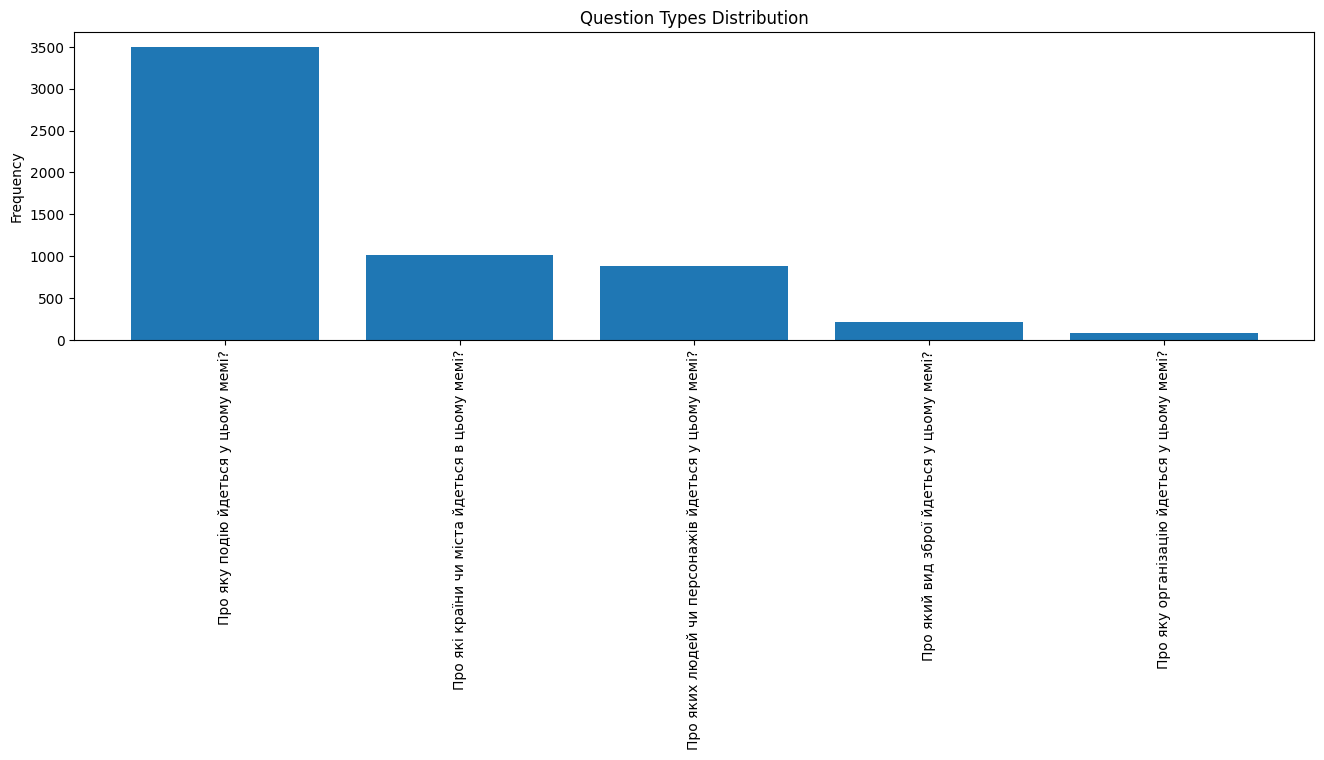

In [29]:
plt.figure(figsize=(16, 4))
plt.bar(question_type_counts.keys(), question_type_counts.values())
plt.title('Question Types Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [30]:
np.array(memes_mvqa_df)

NameError: name 'np' is not defined